# Аттестационное задание No2
## Задача:
Возьмите приложенный набор данных `tips.csv`, где имеются следующие столбцы:
- total_bill - общий счет за столик в ресторане
- tip - чаевые
- sex - кто оплатил счет - мужчина / женщина
- smoker - столик для курящих / некурящих в ресторане
- day - день недели, когда был оплачен счет
- size - количество людей за столиком

Необходимо сформировать правильные аналитические PROMPT запросы для нейросети, чтобы получить следующие ответы
- создание реляционной модели данных для PostgreSQL (на выходе работающие DDL скрипты создания необходимых таблиц)
- создание модели данных Data Vault для PostgreSQL (на выходе работающие DDL скрипты создания необходимых таблиц)
- найти 3 любые Data Insights (закономерности) из предложенного набора данных на основании EDA методологии - Разведочный анализ данных (Exploratory data analysis). На выходе из задания 3 SQL запроса, которые должны подчеркивать найденные бизнес закономерности
- (опционально) вы можете визуально представить найденные Data Inisights в виде Витрин данных (дашбордов) в инструменте SuperSet

In [301]:
import psycopg2
import pandas as pd
import uuid
import hashlib
from tabulate import tabulate

### Подключение к PostgreSQL
connection = psycopg2.connect(
    host="localhost",
    port="5432",
    database="",
    user="",
    password="",
)
### Создание курсора
cursor = connection.cursor()

print("Подключение к PostgreSQL успешно.")

Подключение к PostgreSQL успешно.


## Создание схемы

In [302]:
cursor.execute("CREATE SCHEMA IF NOT EXISTS ivan_patakin;")
connection.commit()
cursor.execute("SET search_path TO ivan_patakin;")

print("Схема 'ivan_patakin' создана. Используется в текущем сеансе.")

Схема 'ivan_patakin' создана. Используется в текущем сеансе.


## Создаем таблицы
### Cоздание реляционной модели данных для PostgreSQL

Создай реляционную модель данных для PostgreSQL на основе следующего набора данных из ресторана:
- total_bill - общий счет за столик в ресторане (числовое поле)
- tip - чаевые (числовое поле)
- sex - кто оплатил счет (мужчина/женщина)
- smoker - столик для курящих/некурящих (да/нет)
- day - день недели, когда был оплачен счет
- time - время приема пищи (обед/ужин)
- size - количество людей за столиком (целое число)

Учти следующие требования:
1. Создай нормализованную модель с разделением справочных данных в отдельные таблицы
2. Используй правильные типы данных для каждого поля
3. Определи первичные и внешние ключи
4. Добавь ограничения целостности данных
5. Предоставь DDL-скрипты для создания таблиц

In [303]:
cursor.execute("""
-- Справочник для пола посетителей
CREATE TABLE sex_dim (
    sex_id SERIAL PRIMARY KEY,
    sex_name VARCHAR(10) NOT NULL UNIQUE CHECK (sex_name IN ('Male', 'Female'))
);

-- Справочник для статуса курящих
CREATE TABLE smoker_dim (
    smoker_id SERIAL PRIMARY KEY,
    smoker_status VARCHAR(3) NOT NULL UNIQUE CHECK (smoker_status IN ('Yes', 'No'))
);

-- Справочник для дней недели
CREATE TABLE day_dim (
    day_id SERIAL PRIMARY KEY,
    day_name VARCHAR(10) NOT NULL UNIQUE
    CHECK (day_name IN ('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
);

-- Справочник для времени приема пищи
CREATE TABLE time_dim (
    time_id SERIAL PRIMARY KEY,
    meal_time VARCHAR(10) NOT NULL UNIQUE
    CHECK (meal_time IN ('Lunch', 'Dinner'))
);

-- Таблица фактов - информация о счетах
CREATE TABLE bills_fact (
    bill_id SERIAL PRIMARY KEY,
    total_bill NUMERIC(6, 2) NOT NULL CHECK (total_bill > 0),
    tip NUMERIC(5, 2) NOT NULL CHECK (tip >= 0),
    sex_id INTEGER NOT NULL REFERENCES sex_dim(sex_id),
    smoker_id INTEGER NOT NULL REFERENCES smoker_dim(smoker_id),
    day_id INTEGER NOT NULL REFERENCES day_dim(day_id),
    time_id INTEGER NOT NULL REFERENCES time_dim(time_id),
    party_size INTEGER NOT NULL CHECK (party_size > 0),
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

-- Заполнение справочников начальными данными
INSERT INTO sex_dim (sex_name) VALUES ('Male'), ('Female');
INSERT INTO smoker_dim (smoker_status) VALUES ('Yes'), ('No');
INSERT INTO day_dim (day_name) VALUES ('Mon'), ('Tue'), ('Wed'), ('Thur'), ('Fri'), ('Sat'), ('Sun');
INSERT INTO time_dim (meal_time) VALUES ('Lunch'), ('Dinner');

-- Создание индексов для повышения производительности запросов
CREATE INDEX idx_bills_sex ON bills_fact(sex_id);
CREATE INDEX idx_bills_day ON bills_fact(day_id);
CREATE INDEX idx_bills_time ON bills_fact(time_id);
CREATE INDEX idx_bills_smoker ON bills_fact(smoker_id);
""")

connection.commit()
print("Таблицы созданы")

Таблицы созданы


In [304]:
# Загрузка данных из CSV
tips_df = pd.read_csv('./Data/Lab2/tips.csv')

# Создание словарей для соответствия значений и ID из справочников
sex_mapping = {'Male': 1, 'Female': 2}
smoker_mapping = {'Yes': 1, 'No': 2}
day_mapping = {'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thur': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
time_mapping = {'Lunch': 1, 'Dinner': 2}

# Подготовка данных для вставки
insert_data = []
for _, row in tips_df.iterrows():
    insert_data.append((
        float(row['total_bill']),
        float(row['tip']),
        sex_mapping[row['sex']],
        smoker_mapping[row['smoker']],
        day_mapping[row['day']],
        time_mapping[row['time']],
        int(row['size'])
    ))

# SQL запрос для вставки данных
insert_query = """
INSERT INTO bills_fact
    (total_bill, tip, sex_id, smoker_id, day_id, time_id, party_size)
VALUES (%s, %s, %s, %s, %s, %s, %s)
"""

# Вставка данных в базу
cursor.executemany(insert_query, insert_data)
connection.commit()

# Проверка количества загруженных записей
cursor.execute("SELECT COUNT(*) FROM bills_fact")
count = cursor.fetchone()[0]
print(f"Загружено {count} записей в таблицу bills_fact")

# Вывод нескольких строк для проверки
cursor.execute("""
SELECT
    bf.bill_id, bf.total_bill, bf.tip,
    sd.sex_name, smd.smoker_status,
    dd.day_name, td.meal_time, bf.party_size
FROM
    bills_fact bf
    JOIN sex_dim sd ON bf.sex_id = sd.sex_id
    JOIN smoker_dim smd ON bf.smoker_id = smd.smoker_id
    JOIN day_dim dd ON bf.day_id = dd.day_id
    JOIN time_dim td ON bf.time_id = td.time_id
LIMIT 5
""")
rows = cursor.fetchall()
columns = ['bill_id', 'total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size']
sample_df = pd.DataFrame(rows, columns=columns)
print("\nПример загруженных данных:")
print(sample_df)

Загружено 244 записей в таблицу bills_fact

Пример загруженных данных:
   bill_id total_bill   tip   sex smoker  day    time  size
0        2      10.34  1.66  Male     No  Sun  Dinner     3
1        3      21.01  3.50  Male     No  Sun  Dinner     3
2        4      23.68  3.31  Male     No  Sun  Dinner     2
3        6      25.29  4.71  Male     No  Sun  Dinner     4
4        7       8.77  2.00  Male     No  Sun  Dinner     2


#### Разведочный анализ данных ресторана: бизнес-закономерности
Проведи разведочный анализ данных (EDA) на основе набора данных ресторана с полями:
- total_bill - общий счет за столик в ресторане
- tip - чаевые
- sex - кто оплатил счет (мужчина/женщина)
- smoker - столик для курящих/некурящих (да/нет)
- day - день недели, когда был оплачен счет
- time - время приема пищи (обед/ужин)
- size - количество людей за столиком

Найди 3 значимые бизнес-закономерности в этих данных и разработай SQL-запросы, которые подтверждают каждую из них.
Для каждой закономерности:
1. Опиши суть закономерности и её бизнес-значение
2. Предоставь SQL-запрос, который выявляет данную закономерность
3. Опиши, как интерпретировать результаты запроса

Используй различные аналитические подходы: анализ соотношений, группировки, агрегации, расчет средних значений,
исследование корреляций между переменными и т.д.

##### Закономерность 1: Влияние дня недели и времени приема пищи на размер счета и чаевых
###### **Суть закономерности**:
Размер счета и процент чаевых существенно различаются в зависимости от дня недели и времени приема пищи. Выходные дни и ужины приносят больше дохода как в абсолютном выражении, так и в проценте чаевых.

###### **Бизнес-значение**:
Позволяет оптимизировать расписание персонала, планировать маркетинговые акции и меню с учетом наиболее доходных дней и времени.

###### **Интерпретация результатов**:
Запрос показывает, какие дни недели и время приема пищи приносят больше всего дохода и чаевых. Результаты позволяют увидеть, что в выходные дни (особенно в субботу и воскресенье) во время ужина размер счета и процент чаевых обычно выше. Это дает возможность планировать работу более опытного персонала на эти дни и оптимизировать меню для максимизации прибыли.

In [305]:
cursor.execute("""
SELECT
    d.day_name,
    t.meal_time,
    COUNT(*) AS visit_count,
    ROUND(AVG(b.total_bill), 2) AS avg_bill,
    ROUND(AVG(b.tip), 2) AS avg_tip,
    ROUND(AVG(b.tip * 100 / b.total_bill), 2) AS avg_tip_percent,
    ROUND(SUM(b.total_bill), 2) AS total_revenue,
    ROUND(SUM(b.tip), 2) AS total_tips
FROM
    bills_fact b
JOIN
    day_dim d ON b.day_id = d.day_id
JOIN
    time_dim t ON b.time_id = t.time_id
GROUP BY
    d.day_name, t.meal_time
ORDER BY
    total_revenue DESC;
""")

# Получение результатов и вывод в табличном виде
rows = cursor.fetchall()
headers = ["День", "Время", "Кол-во визитов", "Ср. счет", "Ср. чаевые",
           "% чаевых", "Общая выручка", "Общие чаевые"]
print(tabulate(rows, headers=headers, tablefmt="grid", numalign="right"))

# Визуализация соотношения общей выручки по дням недели и времени приема пищи
results_df = pd.DataFrame(rows, columns=headers)
print(f"\nАнализ выручки и чаевых по дням недели и времени приема пищи:")
print(f"Общая выручка: {results_df['Общая выручка'].sum():.2f}")
print(f"Общие чаевые: {results_df['Общие чаевые'].sum():.2f}")
print(f"Средний процент чаевых: {results_df['Общие чаевые'].sum() / results_df['Общая выручка'].sum() * 100:.2f}%")

+--------+---------+------------------+------------+--------------+------------+-----------------+----------------+
| День   | Время   |   Кол-во визитов |   Ср. счет |   Ср. чаевые |   % чаевых |   Общая выручка |   Общие чаевые |
+========+=========+==================+============+==============+============+=================+================+
| Sat    | Dinner  |               87 |      20.44 |         2.99 |      15.32 |          1778.4 |          260.4 |
+--------+---------+------------------+------------+--------------+------------+-----------------+----------------+
| Sun    | Dinner  |               76 |      21.41 |         3.26 |      16.69 |         1627.16 |         247.39 |
+--------+---------+------------------+------------+--------------+------------+-----------------+----------------+
| Thur   | Lunch   |               61 |      17.66 |         2.77 |      16.13 |         1077.55 |         168.83 |
+--------+---------+------------------+------------+--------------+-----

##### Закономерность 2: Корреляция между количеством людей за столиком и общей суммой чаевых
###### **Суть закономерности**:
Хотя с увеличением размера компании растет общая сумма чаевых, процент чаевых от суммы счета имеет тенденцию снижаться. При этом есть "оптимальный" размер компании, который дает наилучший баланс между размером счета и процентом чаевых.

###### **Бизнес-значение**:
Позволяет оптимизировать планировку столиков и разработать специальные предложения для групп разного размера.

###### **Интерпретация результатов**:
Запрос демонстрирует, как размер компании влияет на расходы и чаевые. Результаты позволяют определить наиболее прибыльные размеры групп, что может быть использовано для организации пространства ресторана (например, количество столиков на 2, 4 или 6 человек). Также можно выявить, что более крупные группы тратят больше в общем, но меньше в расчете на человека и дают меньший процент чаевых, что можно учесть при разработке групповых предложений.


In [306]:
cursor.execute("""
SELECT
    b.party_size,
    COUNT(*) AS visit_count,
    ROUND(AVG(b.total_bill), 2) AS avg_bill,
    ROUND(AVG(b.tip), 2) AS avg_tip,
    ROUND(AVG(b.tip * 100 / b.total_bill), 2) AS avg_tip_percent,
    ROUND(AVG(b.total_bill / b.party_size), 2) AS avg_per_person,
    ROUND(AVG(b.tip / b.party_size), 2) AS avg_tip_per_person,
    ROUND(SUM(b.total_bill), 2) AS total_revenue
FROM
    bills_fact b
GROUP BY
    b.party_size
ORDER BY
    b.party_size;
""")

# Получение результатов и вывод в табличном виде
rows = cursor.fetchall()
headers = ["Размер группы", "Кол-во визитов", "Ср. счет", "Ср. чаевые",
           "% чаевых", "Ср. на человека", "Чаевые на чел.", "Общая выручка"]
print(tabulate(rows, headers=headers, tablefmt="grid", numalign="right"))

# Анализ данных
results_df = pd.DataFrame(rows, columns=headers)
print(f"\nАнализ зависимости счетов и чаевых от размера группы:")
print(f"Наибольший процент чаевых: {results_df['% чаевых'].max():.2f}% (для групп размером {results_df.loc[results_df['% чаевых'].idxmax()]['Размер группы']} чел.)")
print(f"Наибольшие чаевые на человека: {results_df['Чаевые на чел.'].max():.2f} (для групп размером {results_df.loc[results_df['Чаевые на чел.'].idxmax()]['Размер группы']} чел.)")

+-----------------+------------------+------------+--------------+------------+-------------------+------------------+-----------------+
|   Размер группы |   Кол-во визитов |   Ср. счет |   Ср. чаевые |   % чаевых |   Ср. на человека |   Чаевые на чел. |   Общая выручка |
+=================+==================+============+==============+============+===================+==================+=================+
|               1 |                4 |       7.24 |         1.44 |      21.73 |              7.24 |             1.44 |           28.97 |
+-----------------+------------------+------------+--------------+------------+-------------------+------------------+-----------------+
|               2 |              156 |      16.45 |         2.58 |      16.57 |              8.22 |             1.29 |         2565.89 |
+-----------------+------------------+------------+--------------+------------+-------------------+------------------+-----------------+
|               3 |               38 |   

##### Закономерность 3: Различия в поведении курящих и некурящих посетителей в зависимости от пола
###### **Суть закономерности**:
Существуют значительные различия в поведении между курящими и некурящими посетителями, а также между мужчинами и женщинами в отношении размера чаевых и продолжительности пребывания в ресторане.

###### **Бизнес-значение**:
Понимание этих различий позволяет более эффективно организовать зоны ресторана и обслуживание различных категорий посетителей

###### **Интерпретация результатов**:
Этот запрос анализирует различия в поведении посетителей в зависимости от пола и статуса курильщика. Результаты могут показать, что определенные группы (например, курящие мужчины) могут давать больше чаевых в процентном соотношении или чаще посещать ресторан в определенные дни недели. Такая информация может быть использована для более эффективного распределения официантов по зонам и разработки специальных предложений для разных категорий клиентов.

In [307]:
cursor.execute("""
SELECT
    s.sex_name,
    sm.smoker_status,
    COUNT(*) AS visit_count,
    ROUND(AVG(b.party_size), 2) AS avg_party_size,
    ROUND(AVG(b.total_bill), 2) AS avg_bill,
    ROUND(AVG(b.tip), 2) AS avg_tip,
    ROUND(AVG(b.tip * 100 / b.total_bill), 2) AS avg_tip_percent,
    ROUND(COUNT(CASE WHEN t.meal_time = 'Dinner' THEN 1 END) * 100.0 / COUNT(*), 2) AS dinner_percent,
    ROUND(COUNT(CASE WHEN d.day_name IN ('Sat', 'Sun') THEN 1 END) * 100.0 / COUNT(*), 2) AS weekend_percent
FROM
    bills_fact b
JOIN
    sex_dim s ON b.sex_id = s.sex_id
JOIN
    smoker_dim sm ON b.smoker_id = sm.smoker_id
JOIN
    day_dim d ON b.day_id = d.day_id
JOIN
    time_dim t ON b.time_id = t.time_id
GROUP BY
    s.sex_name, sm.smoker_status
ORDER BY
    avg_tip_percent DESC;
""")

# Получение результатов и вывод в табличном виде
rows = cursor.fetchall()
headers = ["Пол", "Курящий", "Кол-во визитов", "Ср. размер группы", "Ср. счет",
           "Ср. чаевые", "% чаевых", "% ужинов", "% выходных"]
print(tabulate(rows, headers=headers, tablefmt="grid", numalign="right"))

# Анализ результатов
results_df = pd.DataFrame(rows, columns=headers)
print(f"\nАнализ связи между полом, статусом курения и чаевыми:")
print(f"Наибольший процент чаевых: {results_df['% чаевых'].max():.2f}% ({results_df.loc[results_df['% чаевых'].idxmax()]['Пол']}, {results_df.loc[results_df['% чаевых'].idxmax()]['Курящий']})")
print(f"Наименьший процент чаевых: {results_df['% чаевых'].min():.2f}% ({results_df.loc[results_df['% чаевых'].idxmin()]['Пол']}, {results_df.loc[results_df['% чаевых'].idxmin()]['Курящий']})")
print(f"Разница между макс. и мин. процентами чаевых: {results_df['% чаевых'].max() - results_df['% чаевых'].min():.2f}%")

+--------+-----------+------------------+---------------------+------------+--------------+------------+------------+--------------+
| Пол    | Курящий   |   Кол-во визитов |   Ср. размер группы |   Ср. счет |   Ср. чаевые |   % чаевых |   % ужинов |   % выходных |
+========+===========+==================+=====================+============+==============+============+============+==============+
| Female | Yes       |               33 |                2.24 |      17.98 |         2.93 |      18.22 |       69.7 |        57.58 |
+--------+-----------+------------------+---------------------+------------+--------------+------------+------------+--------------+
| Male   | No        |               97 |                2.71 |      19.79 |         3.11 |      16.07 |      79.38 |        77.32 |
+--------+-----------+------------------+---------------------+------------+--------------+------------+------------+--------------+
| Female | No        |               54 |                2.59 |      

### Cоздание модели данных Data Vault для PostgreSQL

Создай модель данных Data Vault для PostgreSQL на основе следующего набора данных из ресторана:
- total_bill - общий счет за столик в ресторане (числовое поле)
- tip - чаевые (числовое поле)
- sex - кто оплатил счет (мужчина/женщина)
- smoker - столик для курящих/некурящих (да/нет)
- day - день недели, когда был оплачен счет
- time - время приема пищи (обед/ужин)
- size - количество людей за столиком (целое число)

Учти следующие требования:
1. Создай полную модель Data Vault с использованием хабов, линков и сателлитов
2. Включи все необходимые технические поля для Data Vault (load_date, record_source и т.д.)
3. Определи бизнес-ключи для хабов
4. Предоставь DDL-скрипты для создания всех таблиц
5. Структурируй модель так, чтобы она соответствовала методологии Data Vault 2.0

In [308]:
cursor.execute("""
-- Добавьте эту строку в начало SQL-скрипта
CREATE EXTENSION IF NOT EXISTS pgcrypto;

-- Затем идет остальная часть вашего кода
CREATE TABLE record_source (
    record_source_id SERIAL PRIMARY KEY,
    record_source_name VARCHAR(100) NOT NULL UNIQUE,
    description TEXT
);

-- Заполним источники данных
INSERT INTO record_source (record_source_name, description)
VALUES ('TIPS_CSV', 'Исходный файл с данными о счетах в ресторане');

-- ХАБЫ - содержат бизнес-ключи

-- Хаб для счетов (каждый счёт как бизнес-сущность)
CREATE TABLE hub_bill (
    hbill_key UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    bill_bk VARCHAR(50) NOT NULL, -- Бизнес-ключ счета (можно использовать синтетический ключ)
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    CONSTRAINT hub_bill_bk_rs UNIQUE (bill_bk, record_source_id)
);

-- Хаб для клиентов (представленных через пол)
CREATE TABLE hub_customer (
    hcust_key UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    customer_bk VARCHAR(10) NOT NULL, -- 'Male' или 'Female'
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    CONSTRAINT hub_customer_bk_rs UNIQUE (customer_bk, record_source_id)
);

-- Хаб для статуса курения
CREATE TABLE hub_smoking_status (
    hsmoke_key UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    smoking_status_bk VARCHAR(3) NOT NULL, -- 'Yes' или 'No'
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    CONSTRAINT hub_smoking_status_bk_rs UNIQUE (smoking_status_bk, record_source_id)
);

-- Хаб для дней недели
CREATE TABLE hub_day (
    hday_key UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    day_bk VARCHAR(10) NOT NULL, -- 'Mon', 'Tue', etc.
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    CONSTRAINT hub_day_bk_rs UNIQUE (day_bk, record_source_id)
);

-- Хаб для времени приема пищи
CREATE TABLE hub_meal_time (
    hmeal_key UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    meal_time_bk VARCHAR(10) NOT NULL, -- 'Lunch' или 'Dinner'
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    CONSTRAINT hub_meal_time_bk_rs UNIQUE (meal_time_bk, record_source_id)
);

-- ЛИНКИ - связи между хабами

-- Линк связывающий счет с атрибутами (пол клиента, статус курения, день, время)
CREATE TABLE link_bill_details (
    lbill_details_key UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    hbill_key UUID NOT NULL REFERENCES hub_bill(hbill_key),
    hcust_key UUID NOT NULL REFERENCES hub_customer(hcust_key),
    hsmoke_key UUID NOT NULL REFERENCES hub_smoking_status(hsmoke_key),
    hday_key UUID NOT NULL REFERENCES hub_day(hday_key),
    hmeal_key UUID NOT NULL REFERENCES hub_meal_time(hmeal_key),
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    CONSTRAINT link_bill_details_natural_key UNIQUE (hbill_key, hcust_key, hsmoke_key, hday_key, hmeal_key)
);

-- САТЕЛЛИТЫ - содержат атрибуты сущностей

-- Сателлит счета - содержит основные атрибуты счета
CREATE TABLE sat_bill (
    hbill_key UUID NOT NULL REFERENCES hub_bill(hbill_key),
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    load_end_date TIMESTAMP NULL, -- для отслеживания истории изменений
    total_bill NUMERIC(6, 2) NOT NULL,
    tip NUMERIC(5, 2) NOT NULL,
    party_size INTEGER NOT NULL,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    hash_diff BYTEA NOT NULL, -- хеш для отслеживания изменений
    is_current BOOLEAN NOT NULL DEFAULT TRUE,
    PRIMARY KEY (hbill_key, load_date)
);

-- Сателлит для клиента - может содержать дополнительные атрибуты клиента
CREATE TABLE sat_customer (
    hcust_key UUID NOT NULL REFERENCES hub_customer(hcust_key),
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    load_end_date TIMESTAMP NULL,
    gender_name VARCHAR(10) NOT NULL,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    hash_diff BYTEA NOT NULL,
    is_current BOOLEAN NOT NULL DEFAULT TRUE,
    PRIMARY KEY (hcust_key, load_date)
);

-- Сателлит для статуса курения
CREATE TABLE sat_smoking_status (
    hsmoke_key UUID NOT NULL REFERENCES hub_smoking_status(hsmoke_key),
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    load_end_date TIMESTAMP NULL,
    status_description VARCHAR(20) NOT NULL,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    hash_diff BYTEA NOT NULL,
    is_current BOOLEAN NOT NULL DEFAULT TRUE,
    PRIMARY KEY (hsmoke_key, load_date)
);

-- Сателлит для дня недели
CREATE TABLE sat_day (
    hday_key UUID NOT NULL REFERENCES hub_day(hday_key),
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    load_end_date TIMESTAMP NULL,
    day_full_name VARCHAR(20) NOT NULL,
    is_weekend BOOLEAN NOT NULL,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    hash_diff BYTEA NOT NULL,
    is_current BOOLEAN NOT NULL DEFAULT TRUE,
    PRIMARY KEY (hday_key, load_date)
);

-- Сателлит для времени приема пищи
CREATE TABLE sat_meal_time (
    hmeal_key UUID NOT NULL REFERENCES hub_meal_time(hmeal_key),
    load_date TIMESTAMP NOT NULL DEFAULT CURRENT_TIMESTAMP,
    load_end_date TIMESTAMP NULL,
    meal_description VARCHAR(50) NOT NULL,
    record_source_id INTEGER NOT NULL REFERENCES record_source(record_source_id),
    hash_diff BYTEA NOT NULL,
    is_current BOOLEAN NOT NULL DEFAULT TRUE,
    PRIMARY KEY (hmeal_key, load_date)
);

-- Индексы для повышения производительности
CREATE INDEX idx_sat_bill_hbill_key ON sat_bill(hbill_key);
CREATE INDEX idx_sat_bill_is_current ON sat_bill(is_current);
CREATE INDEX idx_link_bill_details_hbill_key ON link_bill_details(hbill_key);
CREATE INDEX idx_link_bill_details_hcust_key ON link_bill_details(hcust_key);
CREATE INDEX idx_link_bill_details_hsmoke_key ON link_bill_details(hsmoke_key);
CREATE INDEX idx_link_bill_details_hday_key ON link_bill_details(hday_key);
CREATE INDEX idx_link_bill_details_hmeal_key ON link_bill_details(hmeal_key);

-- Заполнение данными эталонных таблиц
INSERT INTO hub_customer (customer_bk, record_source_id)
VALUES ('Male', 1), ('Female', 1);

INSERT INTO hub_smoking_status (smoking_status_bk, record_source_id)
VALUES ('Yes', 1), ('No', 1);

INSERT INTO hub_day (day_bk, record_source_id)
VALUES ('Mon', 1), ('Tue', 1), ('Wed', 1), ('Thur', 1), ('Fri', 1), ('Sat', 1), ('Sun', 1);

INSERT INTO hub_meal_time (meal_time_bk, record_source_id)
VALUES ('Lunch', 1), ('Dinner', 1);

-- Заполнение сателлитов эталонных данных
INSERT INTO sat_customer (hcust_key, gender_name, record_source_id, hash_diff)
SELECT hcust_key, customer_bk, 1, digest(customer_bk, 'sha256')::bytea
FROM hub_customer;

INSERT INTO sat_smoking_status (hsmoke_key, status_description, record_source_id, hash_diff)
VALUES
((SELECT hsmoke_key FROM hub_smoking_status WHERE smoking_status_bk = 'Yes'), 'Курящий столик', 1, digest('Yes', 'sha256')::bytea),
((SELECT hsmoke_key FROM hub_smoking_status WHERE smoking_status_bk = 'No'), 'Некурящий столик', 1, digest('No', 'sha256')::bytea);

INSERT INTO sat_day (hday_key, day_full_name, is_weekend, record_source_id, hash_diff)
VALUES
((SELECT hday_key FROM hub_day WHERE day_bk = 'Mon'), 'Понедельник', FALSE, 1, digest('Mon', 'sha256')::bytea),
((SELECT hday_key FROM hub_day WHERE day_bk = 'Tue'), 'Вторник', FALSE, 1, digest('Tue', 'sha256')::bytea),
((SELECT hday_key FROM hub_day WHERE day_bk = 'Wed'), 'Среда', FALSE, 1, digest('Wed', 'sha256')::bytea),
((SELECT hday_key FROM hub_day WHERE day_bk = 'Thur'), 'Четверг', FALSE, 1, digest('Thur', 'sha256')::bytea),
((SELECT hday_key FROM hub_day WHERE day_bk = 'Fri'), 'Пятница', FALSE, 1, digest('Fri', 'sha256')::bytea),
((SELECT hday_key FROM hub_day WHERE day_bk = 'Sat'), 'Суббота', TRUE, 1, digest('Sat', 'sha256')::bytea),
((SELECT hday_key FROM hub_day WHERE day_bk = 'Sun'), 'Воскресенье', TRUE, 1, digest('Sun', 'sha256')::bytea);

INSERT INTO sat_meal_time (hmeal_key, meal_description, record_source_id, hash_diff)
VALUES
((SELECT hmeal_key FROM hub_meal_time WHERE meal_time_bk = 'Lunch'), 'Обед', 1, digest('Lunch', 'sha256')::bytea),
((SELECT hmeal_key FROM hub_meal_time WHERE meal_time_bk = 'Dinner'), 'Ужин', 1, digest('Dinner', 'sha256')::bytea);
""")

connection.commit()

print("")

In [309]:
# Загрузка данных из CSV
tips_df = pd.read_csv('./Data/Lab2/tips.csv')

# Функция для генерации хеша
def generate_hash(text):
    return hashlib.sha256(str(text).encode()).digest()

# Загрузка счетов в hub_bill и связанный сателлит
bill_data = []
bill_sat_data = []

# Заполняем hub_bill и sat_bill
for idx, row in tips_df.iterrows():
    # Создаем уникальный бизнес-ключ для каждого счета (используем индекс)
    bill_bk = f'BILL_{idx+1}'

    # Генерируем UUID для счета
    bill_key = str(uuid.uuid4())

    # Данные для хаба счетов
    bill_data.append((bill_key, bill_bk, 1))

    # Данные для сателлита счетов
    hash_value = generate_hash(f"{row['total_bill']}_{row['tip']}_{row['size']}")
    bill_sat_data.append((bill_key, row['total_bill'], row['tip'], row['size'], 1, hash_value))

# Вставка данных в hub_bill
cursor.executemany("""
    INSERT INTO hub_bill (hbill_key, bill_bk, record_source_id)
    VALUES (%s, %s, %s)
""", bill_data)
connection.commit()

# Вставка данных в sat_bill
cursor.executemany("""
    INSERT INTO sat_bill (hbill_key, total_bill, tip, party_size, record_source_id, hash_diff)
    VALUES (%s, %s, %s, %s, %s, %s)
""", bill_sat_data)
connection.commit()

# Получаем хабы для связей
cursor.execute("SELECT hcust_key, customer_bk FROM hub_customer")
customer_map = {row[1]: row[0] for row in cursor.fetchall()}

cursor.execute("SELECT hsmoke_key, smoking_status_bk FROM hub_smoking_status")
smoker_map = {row[1]: row[0] for row in cursor.fetchall()}

cursor.execute("SELECT hday_key, day_bk FROM hub_day")
day_map = {row[1]: row[0] for row in cursor.fetchall()}

cursor.execute("SELECT hmeal_key, meal_time_bk FROM hub_meal_time")
time_map = {row[1]: row[0] for row in cursor.fetchall()}

# Заполняем link_bill_details
link_data = []
cursor.execute("SELECT hbill_key, bill_bk FROM hub_bill")
bill_map = {row[1]: row[0] for row in cursor.fetchall()}

for idx, row in tips_df.iterrows():
    bill_bk = f'BILL_{idx+1}'
    bill_key = bill_map.get(bill_bk)
    customer_key = customer_map.get(row['sex'])
    smoker_key = smoker_map.get(row['smoker'])
    day_key = day_map.get(row['day'])
    time_key = time_map.get(row['time'])

    link_data.append((str(uuid.uuid4()), bill_key, customer_key, smoker_key, day_key, time_key, 1))

# Вставка данных в link_bill_details
cursor.executemany("""
    INSERT INTO link_bill_details
    (lbill_details_key, hbill_key, hcust_key, hsmoke_key, hday_key, hmeal_key, record_source_id)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
""", link_data)
connection.commit()

# Проверка количества загруженных записей
cursor.execute("SELECT COUNT(*) FROM hub_bill")
bill_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM sat_bill")
bill_sat_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM link_bill_details")
link_count = cursor.fetchone()[0]

print(f"Загружено записей:")
print(f"- hub_bill: {bill_count}")
print(f"- sat_bill: {bill_sat_count}")
print(f"- link_bill_details: {link_count}")

# Вывод примера данных для проверки
cursor.execute("""
    SELECT
        b.bill_bk,
        sb.total_bill,
        sb.tip,
        sb.party_size,
        sc.gender_name,
        ss.status_description,
        sd.day_full_name,
        sd.is_weekend,
        sm.meal_description
    FROM hub_bill b
    JOIN sat_bill sb ON b.hbill_key = sb.hbill_key
    JOIN link_bill_details lbd ON b.hbill_key = lbd.hbill_key
    JOIN hub_customer hc ON lbd.hcust_key = hc.hcust_key
    JOIN sat_customer sc ON hc.hcust_key = sc.hcust_key
    JOIN hub_smoking_status hs ON lbd.hsmoke_key = hs.hsmoke_key
    JOIN sat_smoking_status ss ON hs.hsmoke_key = ss.hsmoke_key
    JOIN hub_day hd ON lbd.hday_key = hd.hday_key
    JOIN sat_day sd ON hd.hday_key = sd.hday_key
    JOIN hub_meal_time hm ON lbd.hmeal_key = hm.hmeal_key
    JOIN sat_meal_time sm ON hm.hmeal_key = sm.hmeal_key
    WHERE sb.is_current = TRUE AND sc.is_current = TRUE AND ss.is_current = TRUE
      AND sd.is_current = TRUE AND sm.is_current = TRUE
    LIMIT 5
""")

columns = [
    'bill_bk', 'total_bill', 'tip', 'party_size', 'gender',
    'smoking_status', 'day_name', 'is_weekend', 'meal_time'
]
sample_df = pd.DataFrame(cursor.fetchall(), columns=columns)
print("\nПример загруженных данных Data Vault:")
print(sample_df)

Загружено записей:
- hub_bill: 244
- sat_bill: 244
- link_bill_details: 244

Пример загруженных данных Data Vault:
  bill_bk total_bill   tip  party_size  gender    smoking_status     day_name  \
0  BILL_1      16.99  1.01           2  Female  Некурящий столик  Воскресенье   
1  BILL_2      10.34  1.66           3    Male  Некурящий столик  Воскресенье   
2  BILL_3      21.01  3.50           3    Male  Некурящий столик  Воскресенье   
3  BILL_4      23.68  3.31           2    Male  Некурящий столик  Воскресенье   
4  BILL_5      24.59  3.61           4  Female  Некурящий столик  Воскресенье   

   is_weekend meal_time  
0        True      Ужин  
1        True      Ужин  
2        True      Ужин  
3        True      Ужин  
4        True      Ужин  


##### Закономерность 1: Различия в размере чаевых в зависимости от дня недели и времени приема пищи
###### **Суть закономерности**:
Процент чаевых значительно различается в разные дни недели и время суток. Выявление этой закономерности позволит оптимизировать расписание работы персонала и планирование специальных предложений.

###### **Бизнес-значение**:
Максимизация доходов персонала и ресторана за счет оптимального планирования рабочего графика и специальных предложений в дни с низким показателем чаевых.

###### **Интерпретация результатов**:
Запрос демонстрирует, в какие дни недели и время суток посетители оставляют наибольший процент чаевых. Это позволяет:
1. Распределять более опытных официантов на смены с высоким процентом чаевых
2. Разрабатывать акции или специальные предложения для дней с низким процентом чаевых
3. Анализировать причины различий в щедрости гостей в разные дни и время

In [310]:
cursor.execute("""
SELECT
    d.day_name AS день_недели,
    t.meal_time AS время_приема_пищи,
    COUNT(*) AS количество_посещений,
    ROUND(AVG(b.total_bill), 2) AS средний_счет,
    ROUND(AVG(b.tip), 2) AS средние_чаевые,
    ROUND(AVG(b.tip * 100.0 / b.total_bill), 2) AS процент_чаевых,
    ROUND(SUM(b.total_bill), 2) AS общая_выручка,
    ROUND(SUM(b.tip), 2) AS общая_сумма_чаевых
FROM
    bills_fact b
JOIN
    day_dim d ON b.day_id = d.day_id
JOIN
    time_dim t ON b.time_id = t.time_id
GROUP BY
    d.day_name, t.meal_time
ORDER BY
    процент_чаевых DESC;
""")

# Получение результатов и вывод в табличном виде
rows = cursor.fetchall()
headers = ["День", "Время", "Кол-во визитов", "Ср. счет", "Ср. чаевые",
           "% чаевых", "Общая выручка", "Общие чаевые"]
print(tabulate(rows, headers=headers, tablefmt="grid", numalign="right"))

# Добавим аналитические выводы
results_df = pd.DataFrame(rows, columns=headers)
print(f"\nАнализ чаевых по дням недели и времени приема пищи:")
print(f"Самый высокий процент чаевых: {results_df['% чаевых'].max():.2f}% ({results_df.loc[results_df['% чаевых'].idxmax()]['День']}, {results_df.loc[results_df['% чаевых'].idxmax()]['Время']})")
print(f"Самый низкий процент чаевых: {results_df['% чаевых'].min():.2f}% ({results_df.loc[results_df['% чаевых'].idxmin()]['День']}, {results_df.loc[results_df['% чаевых'].idxmin()]['Время']})")
print(f"Разница между максимальным и минимальным процентом: {results_df['% чаевых'].max() - results_df['% чаевых'].min():.2f}%")

+--------+---------+------------------+------------+--------------+------------+-----------------+----------------+
| День   | Время   |   Кол-во визитов |   Ср. счет |   Ср. чаевые |   % чаевых |   Общая выручка |   Общие чаевые |
+========+=========+==================+============+==============+============+=================+================+
| Fri    | Lunch   |                7 |      12.85 |         2.38 |      18.88 |           89.92 |          16.68 |
+--------+---------+------------------+------------+--------------+------------+-----------------+----------------+
| Sun    | Dinner  |               76 |      21.41 |         3.26 |      16.69 |         1627.16 |         247.39 |
+--------+---------+------------------+------------+--------------+------------+-----------------+----------------+
| Thur   | Lunch   |               61 |      17.66 |         2.77 |      16.13 |         1077.55 |         168.83 |
+--------+---------+------------------+------------+--------------+-----

##### Закономерность 2: Корреляция между размером компании и размером чаевых
###### **Суть закономерности**:
Существует зависимость между количеством гостей за столиком и размером оставляемых чаевых, как в абсолютном выражении, так и в процентном отношении к счету.

###### **Бизнес-значение**:
Понимание этой закономерности позволяет оптимизировать рассадку гостей и разрабатывать специальные предложения для групп разного размера.

###### **Интерпретация результатов**:
Этот запрос показывает:
1. Как меняется средний счет и чаевые в зависимости от размера группы
2. Какие группы оставляют наибольший процент чаевых
3. Какие размеры групп наиболее эффективны с точки зрения дохода ресторана
4. Зависимость расхода на одного человека от размера компании

Это позволяет оптимизировать количество и размер столиков в ресторане, а также разработать специальные предложения для групп определенного размера.

In [311]:
cursor.execute("""
SELECT
    b.party_size AS размер_группы,
    COUNT(*) AS количество_посещений,
    ROUND(AVG(b.total_bill), 2) AS средний_счет,
    ROUND(AVG(b.tip), 2) AS средние_чаевые,
    ROUND(AVG(b.total_bill / b.party_size), 2) AS средний_чек_на_человека,
    ROUND(AVG(b.tip / b.party_size), 2) AS средние_чаевые_на_человека,
    ROUND(AVG(b.tip * 100.0 / b.total_bill), 2) AS процент_чаевых
FROM
    bills_fact b
GROUP BY
    b.party_size
ORDER BY
    b.party_size;
""")

# Получение результатов и вывод в табличном виде
rows = cursor.fetchall()
headers = ["Размер группы", "Кол-во визитов", "Ср. счет", "Ср. чаевые",
           "Ср. чек на чел.", "Ср. чаевые на чел.", "% чаевых"]
print(tabulate(rows, headers=headers, tablefmt="grid", numalign="right"))

# Анализ результатов
results_df = pd.DataFrame(rows, columns=headers)
print(f"\nАнализ зависимости чаевых от размера группы:")
print(f"Наибольший процент чаевых: {results_df['% чаевых'].max():.2f}% (группы по {results_df.loc[results_df['% чаевых'].idxmax()]['Размер группы']} чел.)")
print(f"Наибольшие чаевые на человека: {results_df['Ср. чаевые на чел.'].max():.2f} (группы по {results_df.loc[results_df['Ср. чаевые на чел.'].idxmax()]['Размер группы']} чел.)")
print(f"Наибольший средний чек: {results_df['Ср. счет'].max():.2f} (группы по {results_df.loc[results_df['Ср. счет'].idxmax()]['Размер группы']} чел.)")

+-----------------+------------------+------------+--------------+-------------------+----------------------+------------+
|   Размер группы |   Кол-во визитов |   Ср. счет |   Ср. чаевые |   Ср. чек на чел. |   Ср. чаевые на чел. |   % чаевых |
+=================+==================+============+==============+===================+======================+============+
|               1 |                4 |       7.24 |         1.44 |              7.24 |                 1.44 |      21.73 |
+-----------------+------------------+------------+--------------+-------------------+----------------------+------------+
|               2 |              156 |      16.45 |         2.58 |              8.22 |                 1.29 |      16.57 |
+-----------------+------------------+------------+--------------+-------------------+----------------------+------------+
|               3 |               38 |      23.28 |         3.39 |              7.76 |                 1.13 |      15.22 |
+---------------

##### Закономерность 3: Влияние статуса курильщика и пола на размер чаевых
###### **Суть закономерности**:
Существуют значительные различия в поведении курящих и некурящих гостей, а также между мужчинами и женщинами в отношении размера оставляемых чаевых.

###### **Бизнес-значение**:
Данная закономерность позволяет эффективнее распределять персонал и организовывать пространство ресторана.

###### **Интерпретация результатов**:
Запрос показывает различия в поведении посетителей в зависимости от пола и статуса курильщика:

1. Какие группы клиентов оставляют больше чаевых в процентном соотношении
2. Различия в размере среднего чека между разными группами
3. Предпочтения по размеру групп у разных категорий гостей

Эта информация может быть использована для:
- Распределения персонала (более опытных официантов к группам, оставляющим больше чаевых)
- Оптимизации зонирования ресторана (курящие/некурящие зоны)
- Разработки специальных предложений для различных групп клиентов
- Обучения персонала особенностям обслуживания разных групп гостей

In [312]:
cursor.execute("""
SELECT
    s.sex_name AS пол,
    sm.smoker_status AS курящий,
    COUNT(*) AS количество_посещений,
    ROUND(AVG(b.party_size), 1) AS средний_размер_группы,
    ROUND(AVG(b.total_bill), 2) AS средний_счет,
    ROUND(AVG(b.tip), 2) AS средние_чаевые,
    ROUND(AVG(b.tip * 100.0 / b.total_bill), 2) AS процент_чаевых,
    ROUND(SUM(b.total_bill), 2) AS общая_сумма_счетов,
    ROUND(SUM(b.tip), 2) AS общая_сумма_чаевых
FROM
    bills_fact b
JOIN
    sex_dim s ON b.sex_id = s.sex_id
JOIN
    smoker_dim sm ON b.smoker_id = sm.smoker_id
GROUP BY
    s.sex_name, sm.smoker_status
ORDER BY
    процент_чаевых DESC;
""")

# Получение результатов и вывод в табличном виде
rows = cursor.fetchall()
headers = ["Пол", "Курящий", "Кол-во визитов", "Ср. размер группы", "Ср. счет",
           "Ср. чаевые", "% чаевых", "Общая сумма", "Общие чаевые"]
print(tabulate(rows, headers=headers, tablefmt="grid", numalign="right"))

# Анализ результатов
results_df = pd.DataFrame(rows, columns=headers)
print(f"\nАнализ влияния пола и статуса курения на чаевые:")
print(f"Наибольший процент чаевых: {results_df['% чаевых'].max():.2f}% ({results_df.loc[results_df['% чаевых'].idxmax()]['Пол']}, {results_df.loc[results_df['% чаевых'].idxmax()]['Курящий']})")
print(f"Наименьший процент чаевых: {results_df['% чаевых'].min():.2f}% ({results_df.loc[results_df['% чаевых'].idxmin()]['Пол']}, {results_df.loc[results_df['% чаевых'].idxmin()]['Курящий']})")
print(f"Разница между макс. и мин. процентами чаевых: {results_df['% чаевых'].max() - results_df['% чаевых'].min():.2f}%")
print(f"Группа с наибольшим средним счетом: {results_df.loc[results_df['Ср. счет'].idxmax()]['Пол']}, {results_df.loc[results_df['Ср. счет'].idxmax()]['Курящий']} (${results_df['Ср. счет'].max():.2f})")

+--------+-----------+------------------+---------------------+------------+--------------+------------+---------------+----------------+
| Пол    | Курящий   |   Кол-во визитов |   Ср. размер группы |   Ср. счет |   Ср. чаевые |   % чаевых |   Общая сумма |   Общие чаевые |
+========+===========+==================+=====================+============+==============+============+===============+================+
| Female | Yes       |               33 |                 2.2 |      17.98 |         2.93 |      18.22 |        593.27 |          96.74 |
+--------+-----------+------------------+---------------------+------------+--------------+------------+---------------+----------------+
| Male   | No        |               97 |                 2.7 |      19.79 |         3.11 |      16.07 |       1919.75 |            302 |
+--------+-----------+------------------+---------------------+------------+--------------+------------+---------------+----------------+
| Female | No        |            

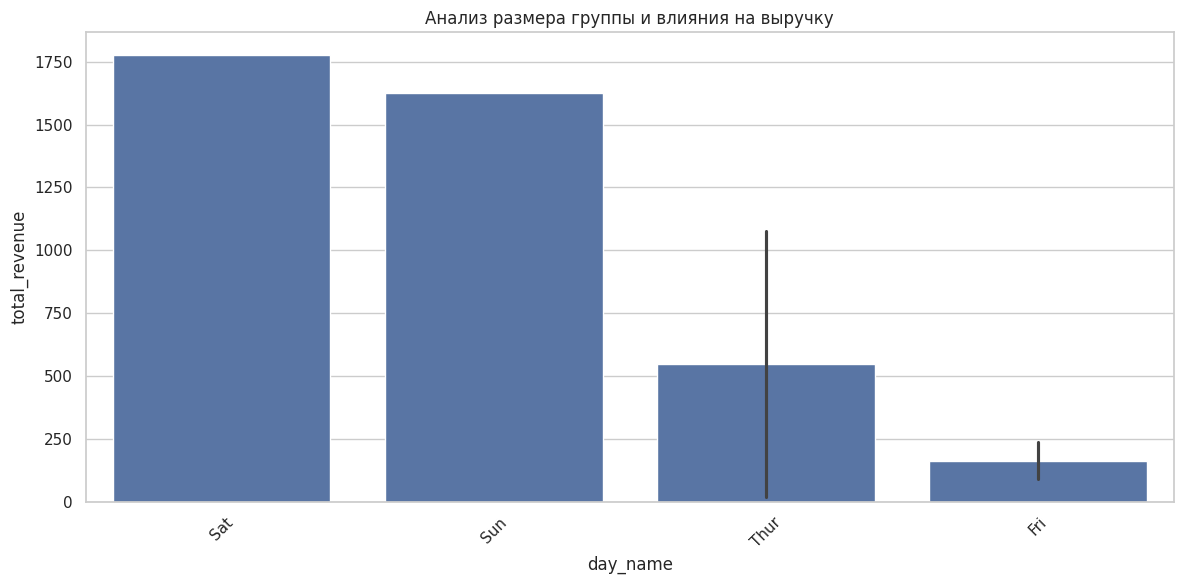

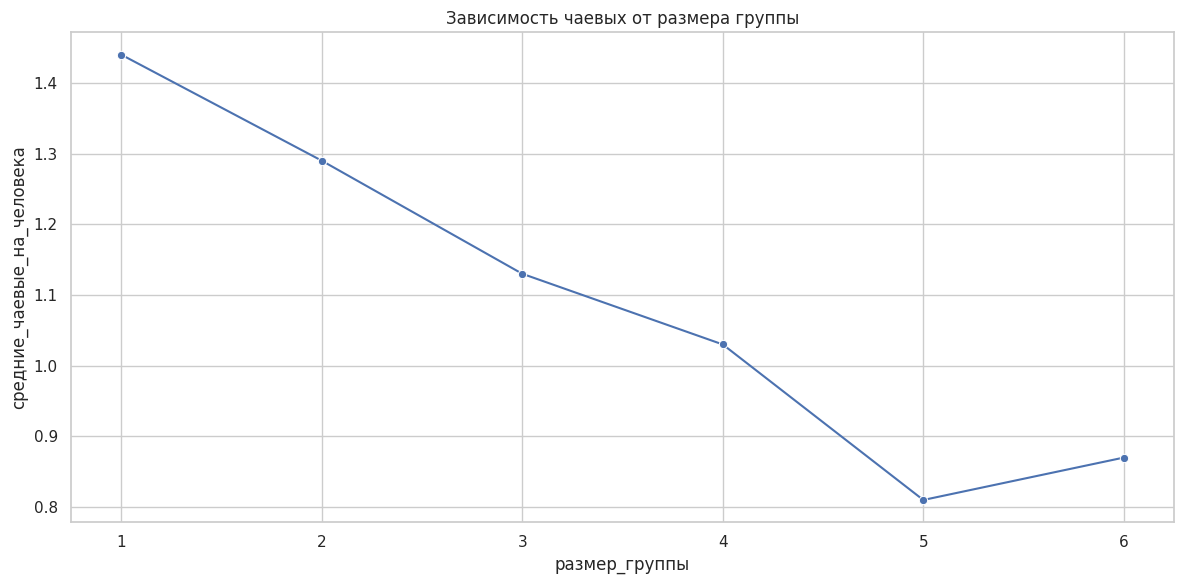

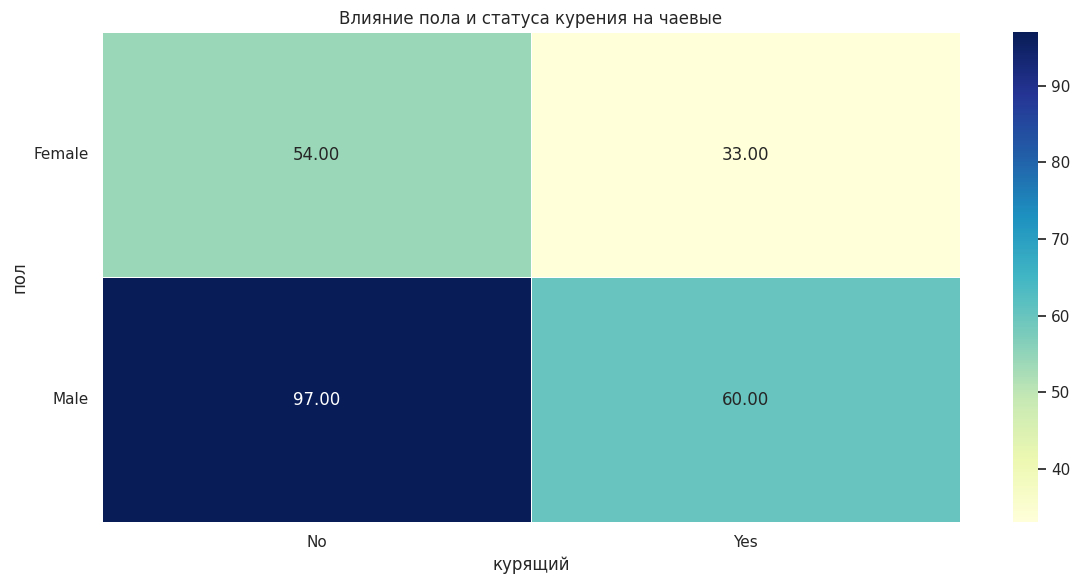

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Настройка стилей для красивой визуализации
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Функция для создания дашбордов на основе SQL-запросов
def create_dashboard(connection, query, title, visualization_type='bar'):
    """
    Создает визуализацию данных на основе SQL-запроса

    Параметры:
    connection - соединение с базой данных
    query - SQL-запрос для получения данных
    title - заголовок визуализации
    visualization_type - тип визуализации (bar, line, pie, heatmap)
    """
    try:
        # Получение данных через курсор вместо pd.read_sql_query
        cursor = connection.cursor()
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=columns)

        if df.empty:
            print(f"Запрос не вернул данных для визуализации: {title}")
            return

        # В зависимости от типа визуализации, создаем разные графики
        plt.figure(figsize=(12, 6))

        if visualization_type == 'bar':
            sns.barplot(x=df.columns[0], y=df.columns[-2], data=df)
            plt.xticks(rotation=45)

        elif visualization_type == 'line':
            sns.lineplot(x=df.columns[0], y=df.columns[-2], data=df, marker='o')

        elif visualization_type == 'pie':
            plt.pie(df[df.columns[-2]], labels=df[df.columns[0]], autopct='%1.1f%%')

        elif visualization_type == 'heatmap':
            # Убедимся, что все данные в числовом формате
            for col in [df.columns[0], df.columns[1], df.columns[2]]:
                if df[col].dtype == 'object':
                    df[col] = df[col].astype(str)

            # Создаем сводную таблицу с явным указанием индексов и столбцов
            pivot_data = df.pivot_table(
                index=df.columns[0],  # первый столбец
                columns=df.columns[1],  # второй столбец
                values=df.columns[2],  # третий столбец (процент чаевых)
                aggfunc='mean'
            )

            # Строим тепловую карту
            sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
            plt.yticks(rotation=0)  # Горизонтальные метки для оси Y

        plt.title(title)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ошибка при создании дашборда: {str(e)}")
        if visualization_type == 'heatmap':
            print(f"Столбцы: {df.columns}")
            print(f"Типы данных: {df.dtypes}")
            print(f"Первые строки: {df.head(2)}")

# SQL-запрос для закономерности 1 (день недели и время приема пищи)
query1 = """
SELECT
    d.day_name,
    t.meal_time,
    COUNT(*) AS visit_count,
    ROUND(AVG(b.total_bill), 2) AS avg_bill,
    ROUND(AVG(b.tip), 2) AS avg_tip,
    ROUND(AVG(b.tip * 100 / b.total_bill), 2) AS avg_tip_percent,
    ROUND(SUM(b.total_bill), 2) AS total_revenue,
    ROUND(SUM(b.tip), 2) AS total_tips
FROM
    bills_fact b
JOIN
    day_dim d ON b.day_id = d.day_id
JOIN
    time_dim t ON b.time_id = t.time_id
GROUP BY
    d.day_name, t.meal_time
ORDER BY
    total_revenue DESC;
"""

# SQL-запрос для закономерности 2 (размер группы)
query2 = """
SELECT
    b.party_size AS размер_группы,
    COUNT(*) AS количество_посещений,
    ROUND(AVG(b.total_bill), 2) AS средний_счет,
    ROUND(AVG(b.tip), 2) AS средние_чаевые,
    ROUND(AVG(b.total_bill / b.party_size), 2) AS средний_чек_на_человека,
    ROUND(AVG(b.tip / b.party_size), 2) AS средние_чаевые_на_человека,
    ROUND(AVG(b.tip * 100.0 / b.total_bill), 2) AS процент_чаевых
FROM
    bills_fact b
GROUP BY
    b.party_size
ORDER BY
    b.party_size;
"""

# SQL-запрос для закономерности 3 (пол и статус курения)
query3 = """
SELECT
    s.sex_name AS пол,
    sm.smoker_status AS курящий,
    COUNT(*) AS количество_посещений,
    ROUND(AVG(b.party_size), 1) AS средний_размер_группы,
    ROUND(AVG(b.total_bill), 2) AS средний_счет,
    ROUND(AVG(b.tip), 2) AS средние_чаевые,
    ROUND(AVG(b.tip * 100.0 / b.total_bill), 2) AS процент_чаевых,
    ROUND(SUM(b.total_bill), 2) AS общая_сумма_счетов,
    ROUND(SUM(b.tip), 2) AS общая_сумма_чаевых
FROM
    bills_fact b
JOIN
    sex_dim s ON b.sex_id = s.sex_id
JOIN
    smoker_dim sm ON b.smoker_id = sm.smoker_id
GROUP BY
    s.sex_name, sm.smoker_status
ORDER BY
    процент_чаевых DESC;
"""

# Создание отдельных визуализаций
create_dashboard(connection, query1, "Анализ размера группы и влияния на выручку", 'bar')
create_dashboard(connection, query2, "Зависимость чаевых от размера группы", 'line')
create_dashboard(connection, query3, "Влияние пола и статуса курения на чаевые", 'heatmap')


In [314]:
cursor.execute("""
-- Отключаем проверку внешних ключей (если необходимо)
SET session_replication_role = 'replica';

-- Удаление сателлитов
DROP TABLE IF EXISTS sat_bill CASCADE;
DROP TABLE IF EXISTS sat_customer CASCADE;
DROP TABLE IF EXISTS sat_smoking_status CASCADE;
DROP TABLE IF EXISTS sat_day CASCADE;
DROP TABLE IF EXISTS sat_meal_time CASCADE;

-- Удаление линков
DROP TABLE IF EXISTS link_bill_details CASCADE;

-- Удаление хабов
DROP TABLE IF EXISTS hub_bill CASCADE;
DROP TABLE IF EXISTS hub_customer CASCADE;
DROP TABLE IF EXISTS hub_smoking_status CASCADE;
DROP TABLE IF EXISTS hub_day CASCADE;
DROP TABLE IF EXISTS hub_meal_time CASCADE;

-- Удаление технических таблиц
DROP TABLE IF EXISTS record_source CASCADE;

-- Удаление таблиц реляционной модели
DROP TABLE IF EXISTS bills_fact CASCADE;
DROP TABLE IF EXISTS sex_dim CASCADE;
DROP TABLE IF EXISTS smoker_dim CASCADE;
DROP TABLE IF EXISTS day_dim CASCADE;
DROP TABLE IF EXISTS time_dim CASCADE;

-- Возвращаем проверку внешних ключей
SET session_replication_role = 'origin';

-- Если необходимо, удаляем расширение
-- DROP EXTENSION IF EXISTS pgcrypto;

-- Удаление всей схемы (альтернативный вариант)
-- DROP SCHEMA IF EXISTS ivan_patakin CASCADE;
""")
connection.commit()

print("Таблицы удалены")

Таблицы удалены


In [315]:
cursor.close()
connection.close()

print("Соединение с PostgreSQL закрыто.")

Соединение с PostgreSQL закрыто.
